# Model5: Best Accuracy

In [1]:
#imports
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import os
from os import listdir
os.environ['KMP_DUPLICATE_LIB_OK']='True' #needed this so that my kernel didn't die when plotting
import warnings
warnings.filterwarnings("ignore")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [12]:
#list of directories
base_directory = "C:/Users/Vansh Aggarwal/Desktop/ai skin pro run"

test_directory = os.path.join(base_directory, 'image_data_test')
train_directory = os.path.join(base_directory, 'image_data_train')
validation_directory = os.path.join(base_directory, 'image_data_validation')
aug_train_directory = os.path.join(base_directory, 'image_data_train_augmented')
bal_validation_directory = os.path.join(base_directory, 'image_data_test_balanced')

In [4]:
#importing pre-trained model
# from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import MobileNetV2

In [5]:
#assigning model to variable to add to new model
#top fully connected layers not included
prior = MobileNetV2(include_top =  False, weights = "imagenet", input_shape = (150, 150, 3))

In [6]:
model = Sequential()

model.add(prior)

model.add(Flatten())
# model.add(Dropout(rate = 0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(rate = 0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax'))

#freeze MobileNet layers so that imagenet weights can be used
for layer in model.layers[0].layers:
    layer.trainable = False

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16384512  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [8]:
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['acc'])

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
#class weights used to give more emphasis to the melanomic classes
class_weights = {
    0: 1,
    1: 1,
    2: 2,
    3: 1,
    4: 1,
    5: 1,
    6: 2
}

In [13]:
#largest target size used for images
#increasing batch size made a difference
train_generator = train_datagen.flow_from_directory(
        aug_train_directory,
        target_size=(150, 150), 
        batch_size= 256,
        class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
        bal_validation_directory,
        target_size=(150, 150),
        batch_size= 256,
        class_mode='categorical')

Found 29051 images belonging to 7 classes.
Found 196 images belonging to 7 classes.


In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (256, 150, 150, 3)
labels batch shape: (256, 7)


In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor= "val_loss", patience = 5, restore_best_weights= True),
             ReduceLROnPlateau(monitor="loss", patience = 2)]


# #model5

In [16]:
import numpy as np

#important to make sure steps are related to the batch size and image count
history = model.fit_generator(
      train_generator,
      steps_per_epoch= len(train_generator),
      epochs=20,
      validation_data=validation_generator,
      validation_steps= len(validation_generator),
      callbacks= callbacks,
      class_weight= class_weights
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp1b17hfaz.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp1b17hfaz.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
114/114 [==============================] - 399s 3s/step - loss: 3.4634 - acc: 0.2065 - val_loss: 1.5558 - val_acc: 0.4031
Epoch 2/20
114/114 [==============================] - 373s 3s/step - loss: 2.0347 - acc: 0.3427 - val_loss: 1.5581 - val_acc:

In [17]:
model.save("mymodel5.h5")

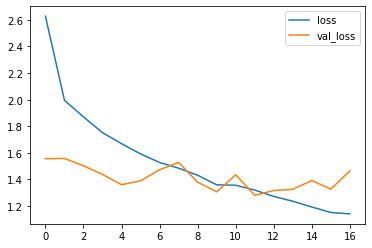

In [18]:
#plot of loss for train and val
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend();

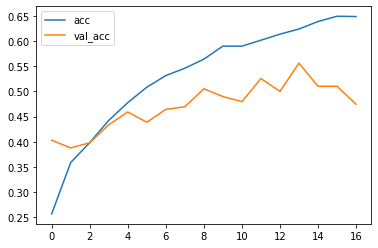

In [19]:
#plot of accuracy for train and val
plt.plot(history.history["acc"], label = "acc")
plt.plot(history.history["val_acc"], label = "val_acc")
plt.legend();

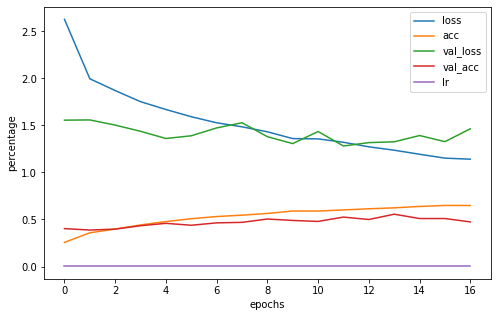

In [87]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel("epochs")
plt.ylabel("percentage")
plt.show()

## Summary:

This is the best that a model has performed so far with the balanced validation data. There is clear overfitting and we are not sure why the model is not learning past a certain point. Slowing the learning rate down seems only to have helped the training data, not the testing data. After reading about batch size influence, manipulating the batch size to be larger than 32 definitely increased accuracy. In the future, I would like to use a platform like AWS to run my more time consuming models so that I can use a larger input image and run more tests. 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, load_model
import keras
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os

In [45]:
#directory imports
base_dir = "C:/Users/Vansh Aggarwal/Desktop/ai skin pro run"

test_directory = os.path.join(base_dir, "image_data_test_balanced")

In [46]:
#instantiating ImageGenerator to pull test images for predictions
test_data_gen = ImageDataGenerator(rescale= 1./255)

In [47]:
batch_size = 256

test_generator7 = test_data_gen.flow_from_directory(test_directory, target_size = (150,150), batch_size = 256, shuffle = False)

model = load_model("C:/Users/Vansh Aggarwal/Desktop/skin_lesion_cnn-master/skin_lesion_cnn-master/skin_lesion_cnn-master/cnn_models/mymodel5.h5")



Found 196 images belonging to 7 classes.


In [48]:
len(test_generator7)

1

In [49]:
preds = model.predict(test_generator7, steps = len(test_generator7))
preds7 = np.argmax(preds, axis =1)


In [50]:
y_true = test_generator7.classes
accuracy_score(y_true, preds7)

0.5255102040816326

In [51]:
print(classification_report(y_true, preds7))

              precision    recall  f1-score   support

           0       0.60      0.11      0.18        28
           1       0.60      0.54      0.57        28
           2       0.29      0.68      0.40        28
           3       0.89      0.29      0.43        28
           4       0.57      0.89      0.69        28
           5       0.95      0.75      0.84        28
           6       0.48      0.43      0.45        28

    accuracy                           0.53       196
   macro avg       0.63      0.53      0.51       196
weighted avg       0.63      0.53      0.51       196



In [52]:
pd.DataFrame(confusion_matrix(y_true, preds7), 
             columns = ["pred_0", "pred_1", "pred_2", "pred_3", "pred_4", "pred_5", "pred_6"],
             index = ["true_0", "true_1", "true_2", "true_3", "true_4", "true_5", "true_6"])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6
true_0,3,4,16,0,0,0,5
true_1,2,15,9,0,1,0,1
true_2,0,3,19,0,4,0,2
true_3,0,2,7,8,9,0,2
true_4,0,0,3,0,25,0,0
true_5,0,0,2,0,2,21,3
true_6,0,1,10,1,3,1,12


In [53]:
print(classification_report(y_true, preds7))

              precision    recall  f1-score   support

           0       0.60      0.11      0.18        28
           1       0.60      0.54      0.57        28
           2       0.29      0.68      0.40        28
           3       0.89      0.29      0.43        28
           4       0.57      0.89      0.69        28
           5       0.95      0.75      0.84        28
           6       0.48      0.43      0.45        28

    accuracy                           0.53       196
   macro avg       0.63      0.53      0.51       196
weighted avg       0.63      0.53      0.51       196



In [69]:
from tensorflow.keras.preprocessing import image
from PIL import Image 
import PIL

In [95]:
dir_path='C:/Users/Vansh Aggarwal/Desktop/skin_lesion_cnn-master/skin_lesion_cnn-master/skin_lesion_cnn-master/cnn_models/test'
for i in os.listdir(dir_path):
  
    img=image.load_img(dir_path+'//'+i,target_size=(150,150))
    img1=img
    plt.imshow(img)
    plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
#     print(images)
    val=model.predict(images)
    hu=np.argmax(val, axis =1)
    if hu==0:
        print("Melanocytic nevi")
    elif hu==1:
        print("dermatofibroma")
    elif hu==2:
        print("Benign keratosis-like lesions")
    elif hu==3:
        print("Basal cell carcinoma")
    elif hu==4:
        print("Actinic keratoses")
    elif hu==5:
        print("Vascular lesions")
    elif hu==6:
        print("melanoma")
        

Benign keratosis-like lesions
Benign keratosis-like lesions
Basal cell carcinoma
Basal cell carcinoma
Actinic keratoses
Actinic keratoses
Actinic keratoses
Vascular lesions
Vascular lesions
Actinic keratoses
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions


In [78]:
dir_path='C:/Users/Vansh Aggarwal/Desktop/skin_lesion_cnn-master/skin_lesion_cnn-master/skin_lesion_cnn-master/cnn_models/test'
count=0
saves='C:/Users/Vansh Aggarwal/Desktop/test2'
for i in os.listdir(dir_path):
    orig=Image.open(dir_path+'//'+i)
    img=image.load_img(dir_path+'//'+i,target_size=(150,150))
#     plt.imshow(img)
#     plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
#     print(images)
    val=model.predict(images)
    hu=np.argmax(val, axis =1)
#     savepath=os.path.join(saves,'type_'+str(hu))
    savepath=saves+'/type_'+str(hu[0])
    if hu==0:
        print("Melanocytic nevi")
    elif hu==1:
        print("dermatofibroma")
    elif hu==2:
        print("Benign keratosis-like lesions")
    elif hu==3:
        print("Basal cell carcinoma")
    elif hu==4:
        print("Actinic keratoses")
    elif hu==5:
        print("Vascular lesions")
    elif hu==6:
        print("melanoma")
    orig.save(f"{savepath}/{count}.jpg")
    
    count=count+1

Vascular lesions
Actinic keratoses
Vascular lesions
Vascular lesions
Actinic keratoses
Vascular lesions
Basal cell carcinoma
Vascular lesions
Actinic keratoses
Actinic keratoses
Actinic keratoses
Basal cell carcinoma
Actinic keratoses
Vascular lesions
Basal cell carcinoma
Vascular lesions
Actinic keratoses
Actinic keratoses
Actinic keratoses
Vascular lesions
Actinic keratoses
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Benign keratosis-like lesions
Vascular lesions
Vascular lesions
Actinic keratoses
Vascular lesions
Actinic keratoses
Vascular lesions
Vascular lesions
Vascular lesions
Benign keratosis-like lesions
Actinic keratoses
Basal cell carcinoma
Vascular lesions
Basal cell carcinoma
Actinic keratoses
Actinic keratoses
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Vascular lesions
Actinic keratoses
Vascular lesions
Vas